TODO: Add PCA and compare with RFE. Add hierarchical clustering with dendogram if time.
<br /> Data doesn't cluster well, basis for needing non-trivial recommendation

In [14]:
import pandas as pd 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#%matplotlib notebook

from sklearn import cross_validation as cv
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

%pylab inline


Populating the interactive namespace from numpy and matplotlib


/home/kristina/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['array', 'test', 'sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [67]:
# datasets provided by https://github.com/llSourcell/recommender_live
dataset1 = '/home/kristina/Downloads/10000.txt'
dataset2 = '/home/kristina/Downloads/song_data.csv'

temp_df1 = pd.read_csv(dataset1, sep="\t", names =["user_id", "song_id", "listen_count"])
temp_df2 = pd.read_csv(dataset2)

#print(len(temp_df1))
#print(len(temp_df2))

#final_df = pd.merge(temp_df1, temp_df2)
final_df = pd.merge(temp_df1, temp_df2.drop_duplicates(['song_id']), on="song_id", how="left")
final_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1.0,The Cove,Thicker Than Water,Jack Johnson,0.0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2.0,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976.0
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1.0,Stronger,Graduation,Kanye West,2007.0
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1.0,Constellations,In Between Dreams,Jack Johnson,2005.0
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1.0,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999.0


In [43]:
final_df["user_id"] = pd.Categorical(final_df["user_id"])
final_df['user_id'] = final_df["user_id"].cat.codes

final_df["song_id"] = pd.Categorical(final_df["song_id"])
final_df['song_id'] = final_df["song_id"].cat.codes

final_df["title"] = pd.Categorical(final_df["title"])
final_df['title'] = final_df["title"].cat.codes

final_df["release"] = pd.Categorical(final_df["release"])
final_df['release'] = final_df["release"].cat.codes

final_df["artist_name"] = pd.Categorical(final_df["artist_name"])
final_df['artist_name'] = final_df["artist_name"].cat.codes

final_df.head()


,user_id,song_id,listen_count,title,release,artist_name,year
0,278,78,1.0,4404,2929,847,0
1,278,233,2.0,1272,946,1385,1976
2,219,233,1.0,1272,946,1385,1976
3,278,414,1.0,4169,1065,982,2007
4,278,414,1.0,4169,1065,982,2007


/home/kristina/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


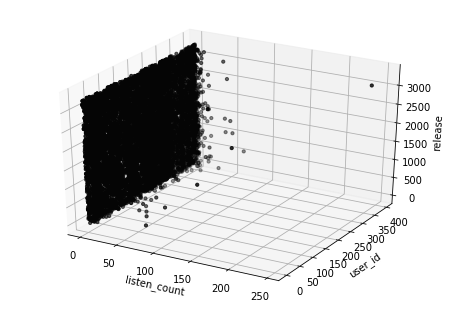

In [44]:
f1 = final_df["listen_count"].values
f2 = final_df["user_id"].values
f3 = final_df["release"].values

#X = np.array(list(zip(f1, f2)))
#plt.plot(f1, f2)
#plt.xlabel('Listed Count')
#plt.ylabel('Song')
#plt.scatter(f1, f2,  c='black', s=20)
#plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(f1, f2, f3,  c='#050505', s=10)
ax.set_xlabel('listen_count')
ax.set_ylabel('user_id')
ax.set_zlabel('release')
fig.show()


In [45]:
final_df = final_df[np.abs(final_df.listen_count-final_df.listen_count.mean())<=(3*final_df.listen_count.std())]

In [37]:
print("Columns " + str(final_df.columns))
array = final_df.values
X = array[:,0:6]
Y = array[:,6]

model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
print("Number " +  str(fit.n_features_))
print("Usable " + str(fit.support_))
print("Ranking " + str(fit.ranking_))

Columns Index(['user_id', 'song_id', 'listen_count', 'title', 'release', 'artist_name',
       'year'],
      dtype='object')
Number 3
Usable [ True False  True False  True False]
Ranking [1 4 1 3 1 2]


In [13]:
array = final_df.values
X = array[:,0:6]
Y = array[:,6]
# feature extraction
test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X, Y)
# summarize scores
numpy.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])

[   6932.669  178998.189    1500.483  252181.126  159017.585  130335.333]
[[   78.  4404.  2929.]
 [  233.  1272.   946.]
 [  233.  1272.   946.]
 [  414.  4169.  1065.]
 [  414.  4169.  1065.]]


In [16]:
from sklearn.ensemble import ExtraTreesClassifier
array = final_df.values
X = array[:,0:6]
Y = array[:,6]
# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.076  0.202  0.051  0.2    0.233  0.238]


/home/kristina/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


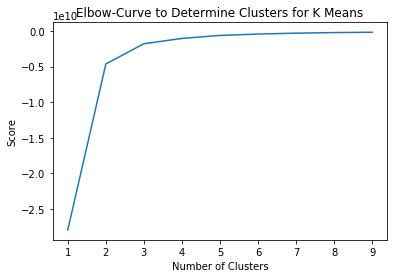

In [62]:
elbow_df = final_df[['user_id','listen_count', 'release']]
elbow_df.fillna(0, inplace=True)
elbow_df = elbow_df.as_matrix()
elbow_df = elbow_df.reshape(-1, 1)

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(elbow_df).score(elbow_df) for i in range(len(kmeans))]

plt.plot(Nc, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow-Curve to Determine Clusters for K Means')
plt.show()

/home/kristina/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


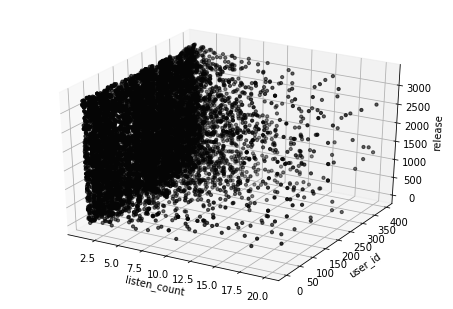

In [63]:
f1 = final_df["listen_count"].values
f2 = final_df["user_id"].values
f3 = final_df["release"].values

#X = np.array(list(zip(f1, f2)))
#plt.plot(f1, f2)
#plt.xlabel('Listed Count')
#plt.ylabel('Song')
#plt.scatter(f1, f2,  c='black', s=20)
#plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(f1, f2, f3,  c='#050505', s=10)
ax.set_xlabel('listen_count')
ax.set_ylabel('user_id')
ax.set_zlabel('release')
fig.show()


[[  1.975e+02   2.483e+00   1.631e+03]
 [  2.010e+02   2.484e+00   2.790e+03]
 [  2.025e+02   2.440e+00   5.732e+02]]


/home/kristina/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


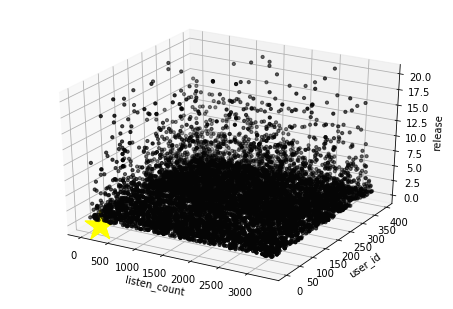

In [60]:
#processed_df = final_df[['user_id','listen_count', 'release']]
processed_df = final_df[['user_id','listen_count', 'release']]

f3 = processed_df["listen_count"].values
f2 = processed_df["user_id"].values
f1 = processed_df["release"].values

df_lcr = processed_df

kmeans = KMeans(n_clusters=3, n_init=10,
 random_state=1)
kmeans = kmeans.fit(df_lcr)
labels = kmeans.predict(df_lcr)
centroid = kmeans.cluster_centers_
print(centroid)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(f1, f2, f3,  c='#050505', s=10)
ax.scatter(centroid[:, 0], centroid[:, 1], marker='*', c='#ffff00', s=1000)
ax.set_xlabel('listen_count')
ax.set_ylabel('user_id')
ax.set_zlabel('release')
fig.show()


[[  2.780e+02   1.000e+00   2.929e+03]]


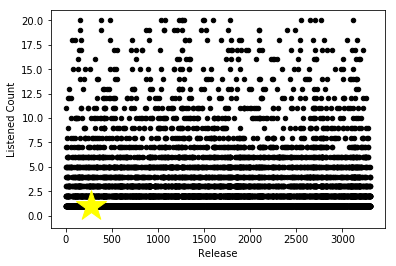

In [52]:
#processed_df = final_df[['user_id','listen_count', 'release']]
processed_df = final_df[['user_id','listen_count', 'release']]

f2 = processed_df["listen_count"].values
f1 = processed_df["release"].values
#f3 = processed_df["release"].values

df_lcr = processed_df.iloc[:1, :3]

kmeans = KMeans(n_clusters=1, n_init=10,
 random_state=1)
kmeans = kmeans.fit(df_lcr)
labels = kmeans.predict(df_lcr)
centroid = kmeans.cluster_centers_
print(centroid)

#X = np.array(list(zip(f1, f2)))
plt.xlabel('Release')
plt.ylabel('Listened Count')
plt.scatter(f1, f2, c='black', s=20)
plt.scatter(centroid[:, 0], centroid[:, 1], marker='*', c='#ffff00', s=1000)
plt.show()


[[ 324.807    2.413]
 [  59.451    2.544]
 [ 197.901    2.461]]


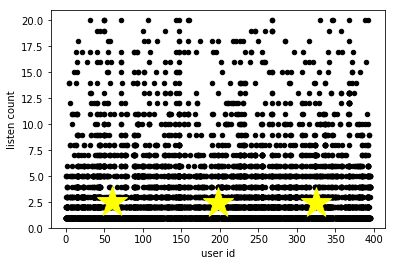

In [53]:
f2 = processed_df["listen_count"].values
f1 = processed_df["user_id"].values

df_lcu = processed_df.iloc[:, :2]

kmeans = KMeans(n_clusters=3, n_init=10,
 random_state=1)
kmeans = kmeans.fit(df_lcu)
labels = kmeans.predict(df_lcu)
centroid = kmeans.cluster_centers_
print(centroid)

plt.xlabel('user id')
plt.ylabel('listen count')
plt.scatter(f1, f2, c='black', s=20)
plt.scatter(centroid[:, 0], centroid[:, 1], marker='*', c='#ffff00', s=1000)
plt.show()

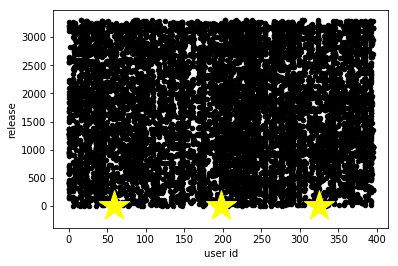

In [64]:
f2 = processed_df["release"].values
f1 = processed_df["user_id"].values
#f3 = processed_df["release"].values

df1 = processed_df.iloc[:, :2]

kmeans = KMeans(n_clusters=3, n_init=10,
 random_state=1)
kmeans = kmeans.fit(df1)
labels = kmeans.predict(df1)
centroid = kmeans.cluster_centers_
#print(centroid)


plt.xlabel('user id')
plt.ylabel('release')
plt.scatter(f1, f2, c='black', s=20)
plt.scatter(centroid[:, 0], centroid[:, 1], marker='*', c='#ffff00', s=1000)
plt.show()

In [45]:
classified_data = kmeans.labels_
cluster_map = df_lcu.copy()
cluster_map['Cluster Class'] = pd.Series(classified_data, index=cluster_map.index)
cluster_map.head(n=10)

,user_id,listen_count,Cluster Class
0,278,1.0,0
1,278,2.0,0
2,219,1.0,0
3,278,1.0,0
4,278,1.0,0
5,246,19.0,0
6,246,19.0,0
7,198,1.0,0
8,198,1.0,0
9,136,2.0,0
